In [1]:
import anndata
import pandas as pd
import scanpy as sc
import scglue

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfo

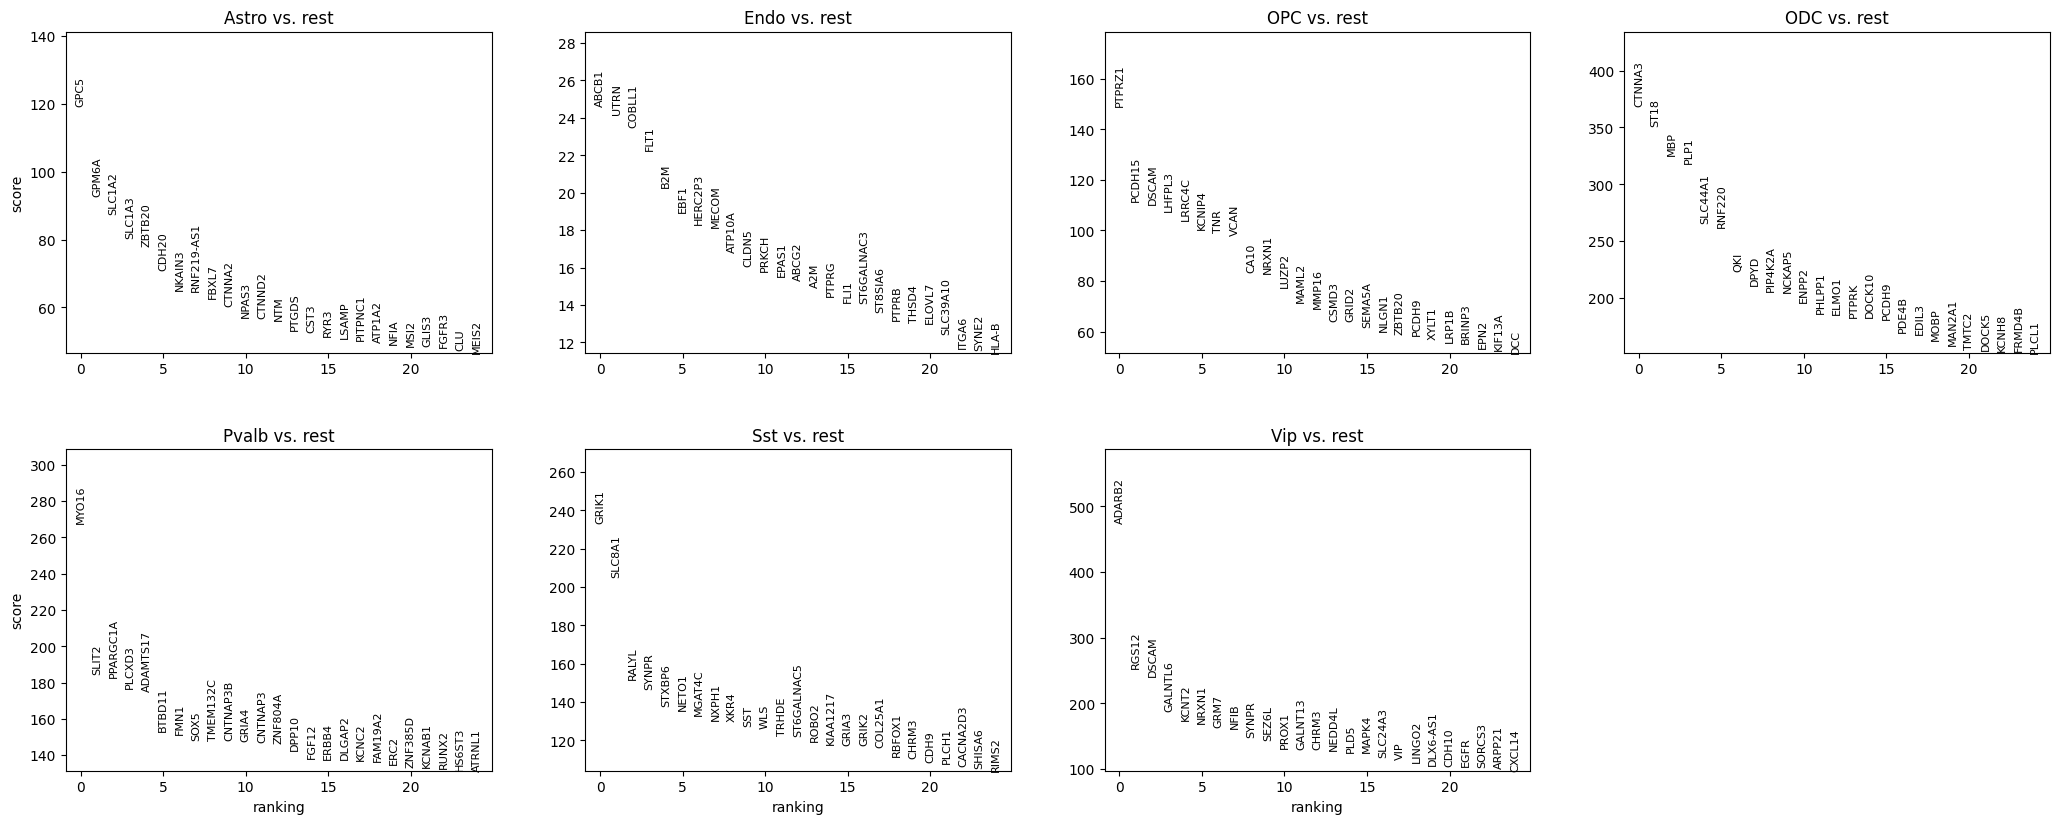

In [2]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/lmh_data/data/sclab/public/gencode.v19.annotation.gtf",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]

sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

In [3]:
rank_genes_groups = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:100]
rank_genes_groups[:20]

,Astro,Endo,OPC,ODC,Pvalb,Sst,Vip
0,GPC5,ABCB1,PTPRZ1,CTNNA3,MYO16,GRIK1,ADARB2
1,GPM6A,UTRN,PCDH15,ST18,SLIT2,SLC8A1,RGS12
2,SLC1A2,COBLL1,DSCAM,MBP,PPARGC1A,RALYL,DSCAM
3,SLC1A3,FLT1,LHFPL3,PLP1,PLCXD3,SYNPR,GALNTL6
4,ZBTB20,B2M,LRRC4C,SLC44A1,ADAMTS17,STXBP6,KCNT2
5,CDH20,EBF1,KCNIP4,RNF220,BTBD11,NETO1,NRXN1
6,NKAIN3,HERC2P3,TNR,QKI,FMN1,MGAT4C,GRM7
7,RNF219-AS1,MECOM,VCAN,DPYD,SOX5,NXPH1,NFIB
8,FBXL7,ATP10A,CA10,PIP4K2A,TMEM132C,XKR4,SYNPR
9,CTNNA2,CLDN5,NRXN1,NCKAP5,CNTNAP3B,SST,SEZ6L


In [4]:
marker_genes = pd.DataFrame()
for index, row in rank_genes_groups.iterrows():
    for cell_type in row.keys():
        marker_genes = pd.concat(
            [
                marker_genes, 
                pd.DataFrame(data=[[row[cell_type], '{}_{}'.format(cell_type, index)]], columns=['gene_name', 'rank'])
            ],
            ignore_index=True
        )
marker_genes = marker_genes.groupby('gene_name')['rank'].apply(list).reset_index(name='rank')
marker_genes = marker_genes.set_index('gene_name')
marker_genes

,rank
gene_name,
A2M,[Endo_13]
ABCA8,[ODC_84]
ABCB1,[Endo_0]
ABCG2,[Endo_12]
ABLIM1,[Astro_40]
...,...
ZNF385D,[Pvalb_20]
ZNF462,[OPC_87]
ZNF804A,[Pvalb_12]


In [5]:
marker_genes = pd.concat([marker_genes, rna.var[['chrom', 'chromStart', 'chromEnd', 'strand']]], axis=1, join='inner')
marker_genes

,rank,chrom,chromStart,chromEnd,strand
A2M,[Endo_13],chr12,9220259.0,9268825.0,-
ABCA8,[ODC_84],chr17,66863432.0,66951533.0,-
ABCB1,[Endo_0],chr7,87133174.0,87342611.0,-
ABCG2,[Endo_12],chr4,89011415.0,89152474.0,-
ABLIM1,[Astro_40],chr10,116190871.0,116444762.0,-
...,...,...,...,...,...
ZNF385D,[Pvalb_20],chr3,21459914.0,22414812.0,-
ZNF462,[OPC_87],chr9,109625377.0,109775915.0,+
ZNF804A,[Pvalb_12],chr2,185463092.0,185804219.0,+
ZNRF3,[Astro_57],chr22,29279579.0,29453475.0,+


In [6]:
marker_genes.to_csv("/lmh_data/data/sclab/sclab/rna_marker_gene.csv", sep='\t')